In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">October 2016</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have received PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simple w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>


# <font color="#E56717">Also find all the patient who have receieved IMRT treamtment (delivery; not just planning)</font>

* <span style="font-size:1.5em;">77418 - IMRT delivery</span>

<span style="font-size:1.5em;">And then use set logic to capture only those PBT patients who did
not also receive IMRT treatment</span>

In [3]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [7]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [8]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [9]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [10]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
len(treatmentindices)

1605

In [14]:
import pickle
fileObject = open('imrt_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [15]:
import pickle
fileObject = open('imrt_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [16]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [17]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
len(controlindices)

62509

In [18]:
puretreatmentindices = list(set(treatmentindices).difference(set(controlindices)))
len(puretreatmentindices)

1526

In [19]:
purecontrolindices = list(set(controlindices).difference(set(treatmentindices)))
len(purecontrolindices)

62430

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id's found above</font>

<span style="font-size:1.1em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011):</span>

* <span style="font-size:1.1em;">pedsf.nasopharynx.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.slivary.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.oropharynx.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.esophagus.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.brain.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.eyeandorbit.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.softtissue.cancer.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file02.txt</span>
* <span style="font-size:1.1em;">pedsf.prostate.cancer.file03.txt</span>
* <span style="font-size:1.1em;">pedsf.lung.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.lung.cancer.flie02.txt</span>
* <span style="font-size:1.1em;">pedsf.breast.cancer.file01.txt</span>
* <span style="font-size:1.1em;">pedsf.breast.cancer.file02.txt</span>

# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [20]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

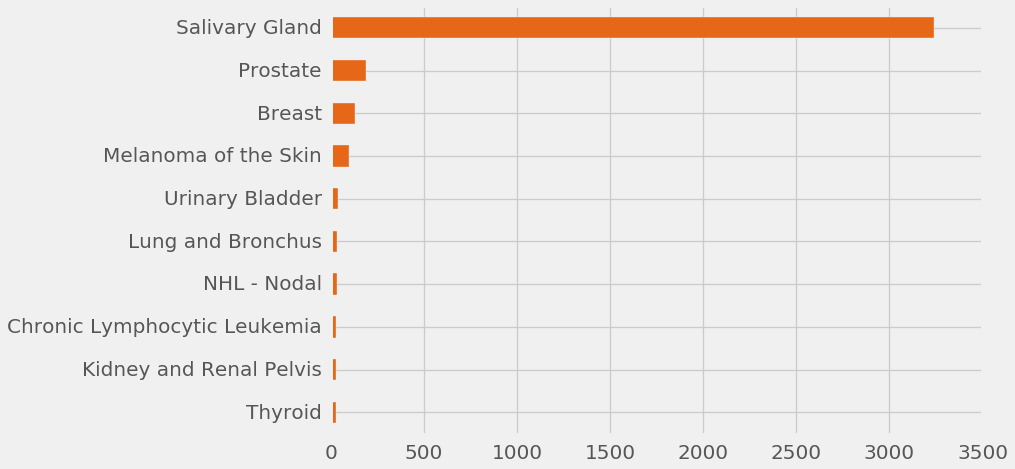

In [21]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing. Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data. Also, only keep those patients that SEER says received radiation (the seer radiation flag also indicates that the radiation was the first course of treament)</span>

* <span style="font-size:1.5em;">1144 PBT patients that did not receive IMRT</span>
* <span style="font-size:1.5em;">47949 IMRT patients that did not receive any PBT</span>

In [22]:
dfall.patient_id.isin(puretreatmentindices).sum()

1526

In [23]:
dfall.patient_id.isin(purecontrolindices).sum()

62430

In [24]:
dfall.shape

(719821, 496)

In [25]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

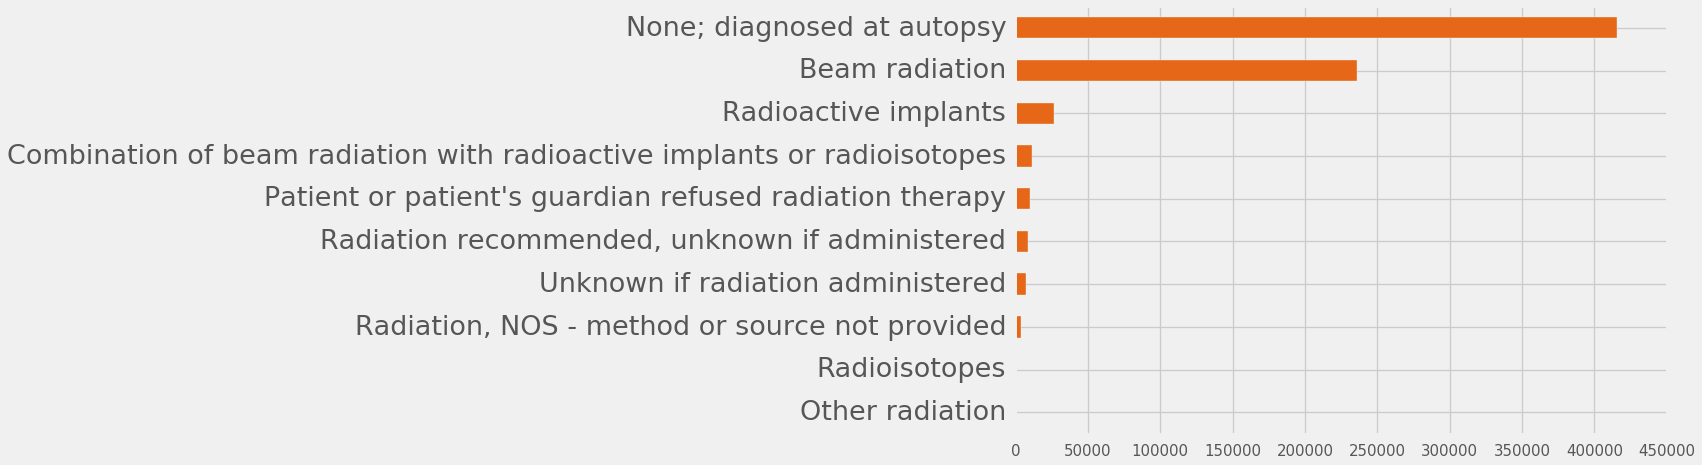

In [26]:
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)

In [27]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()

In [28]:
dfsmall.shape

(278330, 496)

In [29]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(puretreatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [30]:
smallcontrolindices.shape

(47494,)

In [31]:
smalltreatmentindices.shape

(1144,)

In [32]:
set(smalltreatmentindices).issubset(puretreatmentindices) 

True

In [33]:
set(smallcontrolindices).issubset(purecontrolindices)

True

In [34]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [35]:
dfalltreatment.shape, dfallcontrol.shape

((1144, 496), (47494, 496))

# <font color="#E56717">So we are going to match patients who have received PBT (1144 of them) with one of the 47494 patients who have received IMRT as their first course of treatment. These patients have been identified as receiving RT treatmetn delivery in both halves of the SEER-Medicare data</font>

<span style="font-size:1.5em;">We first need to deide on which features (or columns) of the data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [36]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [37]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable cstum1 (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error</span>
* <span style="font-size:1.5em;">Over half of the patents have missing values, or text values instead of numbers</span>

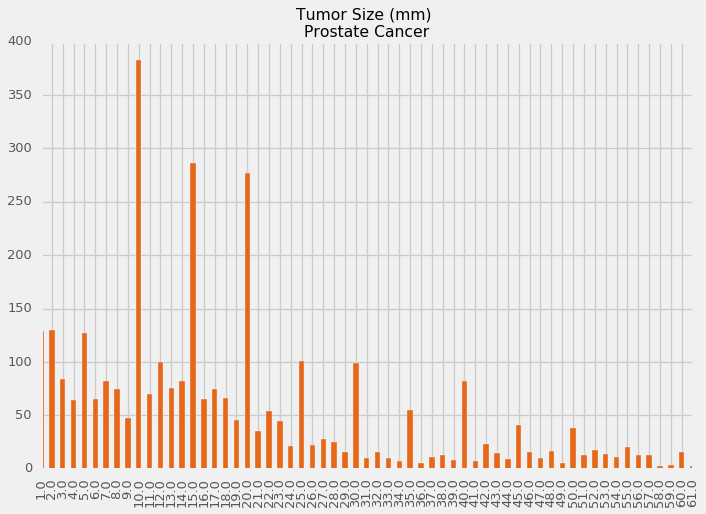

In [38]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",
case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

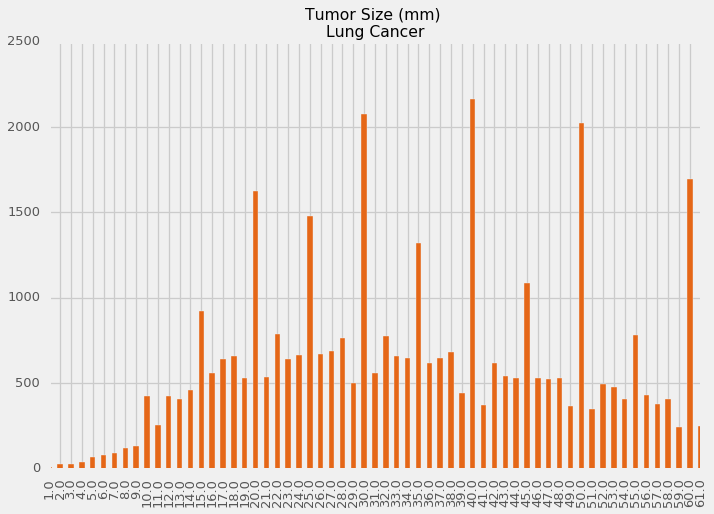

In [39]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,
na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);

# <font color="#E56717">This phenomena is so common it has a name</font>

# End-digit preference

<span style="font-size:1.5em;">"In converting analog to digital data, observers may record some terminal digits with an unusual frequency, for example rounding off may be to the nearest whole number, even number, multiple of 5 or 10, or when time units like a week are involved, 7, 14, etc."<span>

* <span style="font-size:1.2em;">Encyclopedia of Epidemiologic Methods, by By Mitchell H. Gail, Jacques Benichou</span>

In [40]:
catcols = ['m_sex','marst1','srace','nhiade','grade1',
           'site1','lat1',
          'histrec1',
           'modx1','stat_rec']


goodcols = ['m_sex','marst1', 'srace','nhiade',
           'grade1','site1',
           'lat1','histrec1',
           'modx1','stat_rec','birthyr',
           'agedx1',
           'yrdx1','elevation_1',
           'lng_1','lat_1']

In [41]:
dfpop = pd.concat([dfallcontrol, dfalltreatment])

In [42]:
resgoodcontrol = pd.concat([pd.get_dummies(dfallcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfalltreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)


In [43]:
print(goodcols)


['m_sex', 'marst1', 'srace', 'nhiade', 'grade1', 'site1', 'lat1', 'histrec1', 'modx1', 'stat_rec', 'birthyr', 'agedx1', 'yrdx1', 'elevation_1', 'lng_1', 'lat_1']


In [44]:
resgoodcontrol['birthyr'] = dfallcontrol['birthyr']
resgoodcontrol['agedx1'] = dfallcontrol['agedx1']

resgoodcontrol['yrdx1'] = dfallcontrol['yrdx1']


resgoodcontrol['lat_1'] = dfallcontrol['lat_1']

resgoodcontrol['lng_1'] = dfallcontrol['lng_1']

resgoodcontrol['srvm1'] = dfallcontrol['srvm1']

resgoodcontrol['elevation_1'] = dfallcontrol['elevation_1']

In [45]:
resgoodtreatment['birthyr'] = dfalltreatment['birthyr']
resgoodtreatment['agedx1'] = dfalltreatment['agedx1']

resgoodtreatment['yrdx1'] = dfalltreatment['yrdx1']


resgoodtreatment['lat_1'] = dfalltreatment['lat_1']

resgoodtreatment['lng_1'] = dfalltreatment['lng_1']

resgoodtreatment['srvm1'] = dfalltreatment['srvm1']

resgoodtreatment['elevation_1'] = dfalltreatment['elevation_1']

In [46]:
resgoodpop['birthyr'] = dfpop['birthyr']
resgoodpop['agedx1'] = dfpop['agedx1']

resgoodpop['yrdx1'] = dfpop['yrdx1']




resgoodpop['lat_1'] = dfpop['lat_1']

resgoodpop['lng_1'] = dfpop['lng_1']

resgoodpop['srvm1'] = dfpop['srvm1']

resgoodpop['elevation_1'] = dfpop['elevation_1']

In [47]:
resgoodpop['birthyr'] = resgoodpop['birthyr'].astype('int')
resgoodpop['agedx1'] = resgoodpop['agedx1'].astype('float')



resgoodpop['lat_1'] = resgoodpop['lat_1'].astype('float')



resgoodpop['lng_1'] = resgoodpop['lng_1'].astype('float')
resgoodpop['elevation_1'] = resgoodpop['elevation_1'].astype('float')

resgoodpop['srvm1'] = resgoodpop['srvm1'].astype('float')


newcolumns = list(resgoodpop.columns)

newcolumns.remove('srvm1')
newcolumns.remove('stat_rec_Alive')
newcolumns.remove('stat_rec_Dead')
newcolumns.remove('m_sex_Male')

resgreatpop = resgoodpop[newcolumns].copy()

In [48]:
resgreatpop['patient_id'] = resgreatpop.index
leaguefilter = (resgreatpop['patient_id'].loc[smalltreatmentindices])
resgreatpop['League'] = resgreatpop['patient_id'].isin(smalltreatmentindices).astype('int')
del resgreatpop['patient_id']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

In [50]:
print(list(dftree.columns))

['m_sex_Female', 'marst1_Divorced', 'marst1_Married (including common law)', 'marst1_Separated', 'marst1_Single (never married)', 'marst1_Unknown', 'marst1_Unmarried or domesntic partner (same sex or opposite sex or unregistered)', 'marst1_Widowed', 'srace_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)', 'srace_Asian Indian', 'srace_Asian Indian or Pakistani, NOS', 'srace_Black', 'srace_Chinese', 'srace_Fiji Islander', 'srace_Filipino', 'srace_Guamanian, NOS', 'srace_Hawaiian', 'srace_Hmong', 'srace_Japanese', 'srace_Kampuchean (including Khmer and Cambodian)', 'srace_Korean', 'srace_Laotian', 'srace_Melanesian, NOS', 'srace_Micronesian, NOS', 'srace_Other', 'srace_Other Asian, including Asian, NOS and Oriental NOS', 'srace_Pacific Islander, NOS', 'srace_Pakistani', 'srace_Polynesian, NOS', 'srace_Samoan', 'srace_Thai', 'srace_Tongan', 'srace_Unknown', 'srace_Vietnamese', 'srace_White', 'nhiade_Cuban', 'nhiade_Dominica

<span style="font-size:1.5em;">This brute force method of finding similar patients in a high-dimensional space is possible thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, agedx1 is on the order of 60 or so, while birthyr is around 1960. Without standardization, birthyr would contribute much more to the distance between patients than agedx1. The result of standardization (or z-score normalization) is that features will be rescaled so that they will have</span>

$\mu = 0$ and $\sigma = 1$, where $\mu$ is the mean and $\sigma$ is the standard deviation; z-scores are then calculated as follows:

$z_{i} = \frac{x_{i} - \mu}{\sigma}$

In [51]:
dftree.shape

(48638, 182)

In [52]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[ 1.84575552 -0.27678472 -1.34084306 ...,  0.9176452   1.12672791
   0.2379046 ]
 [-0.54178356 -0.27678472  0.74579944 ...,  0.81691711  1.15082489
  -0.572579  ]
 [-0.54178356 -0.27678472 -1.34084306 ...,  0.84826952  1.1677207
  -0.66180816]
 ..., 
 [ 1.84575552 -0.27678472  0.74579944 ..., -0.57758389 -1.07464503
   1.53299448]
 [ 1.84575552 -0.27678472  0.74579944 ..., -0.79788207 -1.12448289
   0.03392982]
 [ 1.84575552 -0.27678472  0.74579944 ..., -0.57758389 -1.07464503
   1.53299448]]


In [53]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

# <font color="#E56717">Here is a video explaining the construction of a KDTree</font>

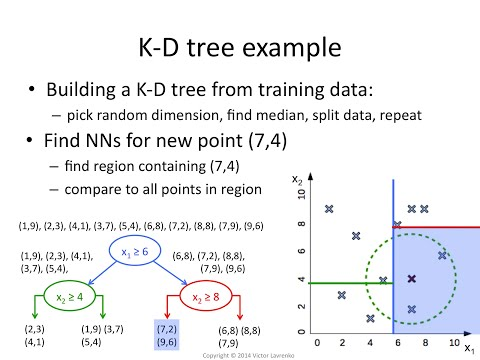

In [54]:
from IPython.display import YouTubeVideo
YouTubeVideo('Y4ZgLlDfKDg')

In [55]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

# <font color="#E56717">Finding the distance to all of the 4 nearest neighbors only took 3 minutes!<font>

In [56]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [57]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

dist1filter = (dftreeleague['distance_1'] <= 2)
dist2filter = (dftreeleague['distance_2'] <= 2)
dist3filter = (dftreeleague['distance_3'] <= 2)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
patient_id,,,
4473112043,4408106073,0.647362,0
8851092441,8841081424,1.907165,0
8870085471,8835013250,1.849769,0
8889005430,8848090384,1.156120,0
4247072024,8797035478,1.562822,0
0230482051,4484106095,0.602601,0
0231464080,4496122052,0.455806,0
0247481030,0256490040,0.168248,0
0266443090,0281432030,0.000000,0


In [58]:
onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict, threedict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodtreatmentteams = list(dd.keys())

goodcontrolteams = list(dd.values())
matches = list(set([item for sublist in goodcontrolteams for item in sublist]))

controlindices = matches
treatmentindices = goodtreatmentteams
print(len(treatmentindices))
print(len(controlindices))

853
1833


# <font color="#E56717">Need to do a one-to-one matching (where each member of the treatment group is matched to one and only one member of the control group, and where that matched control corresponds to only one member of the treatment group</font>

In [59]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_t_c = {}

for key, value in d_one_to_one.items():
    if value not in d_t_c.values():
        d_t_c[key] = value
        
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())   

In [60]:
treatmentindices = list(d_t_c.keys())
controlindices = list(d_t_c.values())

print(len(controlindices), len(treatmentindices))

790 790


# <font color="#E56717">So we hve 790 pure PBT treatment patients matched very closely to 790 pure IMRT control patients</font> 

In [62]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srvm1"]
Econtrol = resgoodpop.loc[controlindices]["stat_rec_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srvm1"]
Etreatment = resgoodpop.loc[treatmentindices]["stat_rec_Dead"]

Tpop = resgoodpop["srvm1"]
Epop = resgoodpop["stat_rec_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='IMRT Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='PBT Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");
import mpld3

# <font color="#E56717">Now here is the Kaplan-Meier plot of the post-matching treatment and control groups</font>

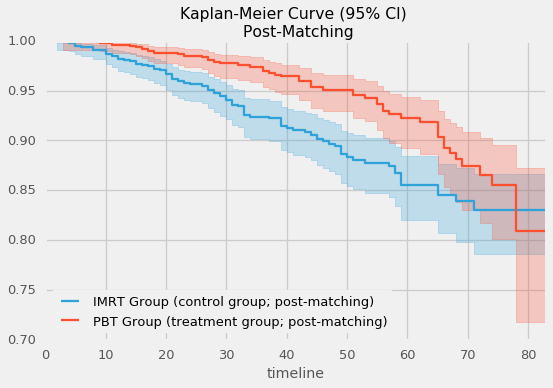

In [63]:
mpld3.enable_notebook()
ax = kmfcontrolpost.plot(figsize=(8,5))
kmftreatmentpost.plot(ax=ax)
plt.title("Kaplan-Meier Curve (95% CI) \n Post-Matching");

# <font color="#E56717">We can perform a rigorous test to see if the two survival curves truly have different DGPs (data generation processes)</font>

In [64]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   test: logrank
   alpha: 0.95
   t 0: -1
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00297 |              8.826 |      Reject Null    |        True       


In [65]:
import pickle
fileObject = open('pure_control_indicies.pickle','wb')
pickle.dump(controlindices, fileObject)
fileObject.close()

In [66]:
import pickle
fileObject = open('pure_treatment_indicies.pickle','wb')
pickle.dump(treatmentindices, fileObject)
fileObject.close()

In [67]:
df = df.set_index('patient_id',drop=False)

# <font color="#E56717">Investigate the results of the matching</font>


# <font color="#E56717">Gender breakdown</font>

In [68]:
df['m_sex'][df['patient_id'].isin(treatmentindices)].value_counts()

Male      780
Female     10
Name: m_sex, dtype: int64

In [69]:
df['m_sex'][df['patient_id'].isin(controlindices)].value_counts()

Male      780
Female     10
Name: m_sex, dtype: int64

# <font color="#E56717">Marital status breakdown</font>

In [70]:
df['marst1'][df['patient_id'].isin(treatmentindices)].value_counts()

Married (including common law)    628
Single (never married)             48
Divorced                           45
Unknown                            36
Widowed                            28
Separated                           5
Name: marst1, dtype: int64

In [71]:
df['marst1'][df['patient_id'].isin(controlindices)].value_counts()

Married (including common law)    628
Single (never married)             48
Divorced                           45
Unknown                            36
Widowed                            28
Separated                           5
Name: marst1, dtype: int64

# <font color="#E56717">Racial breakdown</font>

In [72]:
df['srace'][df['patient_id'].isin(treatmentindices)].value_counts()

White                                                                                                                 736
Black                                                                                                                  32
Chinese                                                                                                                 6
Filipino                                                                                                                6
Other Asian, including Asian, NOS and Oriental NOS                                                                      4
Japanese                                                                                                                3
Korean                                                                                                                  2
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

In [73]:
df['srace'][df['patient_id'].isin(controlindices)].value_counts()

White                                                                                                                 736
Black                                                                                                                  32
Chinese                                                                                                                 6
Filipino                                                                                                                6
Other Asian, including Asian, NOS and Oriental NOS                                                                      4
Japanese                                                                                                                3
Korean                                                                                                                  2
American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)      1
Name: srace, dtype: int6

# <font color="#E56717">nhiade breakdown</font>

In [74]:
df['nhiade'][df['patient_id'].isin(treatmentindices)].value_counts()

Non-Spanish-Hispanic-Latino                   743
Spanish/Hispanic/Latino, NOS                   29
Mexican                                         7
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

In [75]:
df['nhiade'][df['patient_id'].isin(controlindices)].value_counts()

Non-Spanish-Hispanic-Latino                   743
Spanish/Hispanic/Latino, NOS                   29
Mexican                                         7
NHIA Surname Match Only                         7
South or Central American excluding Brazil      3
Cuban                                           1
Name: nhiade, dtype: int64

# <font color="#E56717">Grade breakdown</font>

In [76]:
df['grade1'][df['patient_id'].isin(treatmentindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               422
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    350
cell type not determined, not stated or not applicable                                                              14
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  2
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            2
Name: grade1, dtype: int64

In [77]:
df['grade1'][df['patient_id'].isin(controlindices)].value_counts()

Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               422
Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    350
cell type not determined, not stated or not applicable                                                              14
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                  2
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            2
Name: grade1, dtype: int64

# <font color="#E56717">Site breakdown</font>

In [78]:
df['site1'][df['patient_id'].isin(treatmentindices)].value_counts()

Prostate gland                    772
Upper lobe, lung                    8
Upper-outer quadrant of breast      2
Choroid                             2
Overlapping lesion of breast        1
Parietal lobe                       1
Frontal lobe                        1
Temporal lobe                       1
Lower third of esophagus            1
Lower-inner quadrant of breast      1
Name: site1, dtype: int64

In [79]:
df['site1'][df['patient_id'].isin(controlindices)].value_counts()

Prostate gland                    772
Upper lobe, lung                    8
Upper-outer quadrant of breast      2
Choroid                             2
Overlapping lesion of breast        1
Parietal lobe                       1
Frontal lobe                        1
Temporal lobe                       1
Lower third of esophagus            1
Lower-inner quadrant of breast      1
Name: site1, dtype: int64

# <font color="#E56717">Histology breakdown</font>

In [80]:
df['histrec1'][df['patient_id'].isin(treatmentindices)].value_counts()

8140-8398: adenomas and adenocarcinomas    775
8500-8549: ductal and lobular neoplasms      4
8050-8089: squamous cell neplasms            3
9380-9489: gliomas                           3
8010-8049: epithelial neplasms, NOS          2
8720-8799: nevi and melanomas                2
8560-8579: complex epithelial neoplasms      1
Name: histrec1, dtype: int64

In [81]:
df['histrec1'][df['patient_id'].isin(controlindices)].value_counts()

8140-8398: adenomas and adenocarcinomas    775
8500-8549: ductal and lobular neoplasms      4
8050-8089: squamous cell neplasms            3
9380-9489: gliomas                           3
8010-8049: epithelial neplasms, NOS          2
8720-8799: nevi and melanomas                2
8560-8579: complex epithelial neoplasms      1
Name: histrec1, dtype: int64

# <font color="#E56717">Month of diagnosis breakdown</font>

In [82]:
df['modx1'][df['patient_id'].isin(treatmentindices)].value_counts()

Feb    78
Jun    74
Aug    74
Mar    73
Jan    69
Oct    68
Jul    65
Nov    64
May    64
Apr    63
Sep    50
Dec    45
Name: modx1, dtype: int64

In [83]:
df['modx1'][df['patient_id'].isin(controlindices)].value_counts()

Feb    78
Jun    74
Aug    74
Mar    73
Jan    69
Oct    68
Jul    65
Nov    64
May    64
Apr    63
Sep    50
Dec    45
Name: modx1, dtype: int64

# <font color="#E56717">birthyr breakdown</font>

In [84]:
df['birthyr'][df['patient_id'].isin(treatmentindices)].describe()

count     790.000000
mean     1937.087342
std         5.472245
min      1921.000000
25%      1934.000000
50%      1938.000000
75%      1941.000000
max      1957.000000
Name: birthyr, dtype: float64

In [85]:
df['birthyr'][df['patient_id'].isin(controlindices)].describe()

count     790.000000
mean     1936.740506
std         5.220342
min      1920.000000
25%      1933.250000
50%      1937.000000
75%      1941.000000
max      1953.000000
Name: birthyr, dtype: float64

# <font color="#E56717">Age at diagnosis breakdown</font>

In [86]:
df['agedx1'][df['patient_id'].isin(treatmentindices)].describe()

count    790.000000
mean      70.875949
std        5.262663
min       53.000000
25%       67.000000
50%       70.000000
75%       74.000000
max       89.000000
Name: agedx1, dtype: float64

In [87]:
df['agedx1'][df['patient_id'].isin(controlindices)].describe()

count    790.000000
mean      71.137975
std        5.035232
min       55.000000
25%       67.000000
50%       71.000000
75%       74.000000
max       88.000000
Name: agedx1, dtype: float64

# <font color="#E56717">Laterality breakdown</font>

In [88]:
df['lat1'][df['patient_id'].isin(treatmentindices)].value_counts()

Not a paired site           773
Right: origin of primary     10
Left: origin of primary       7
Name: lat1, dtype: int64

In [89]:
df['lat1'][df['patient_id'].isin(controlindices)].value_counts()


Not a paired site           773
Right: origin of primary     10
Left: origin of primary       7
Name: lat1, dtype: int64

# <font color="#E56717">latitude breakdown</font>

In [90]:
df['lat_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    790.000000
mean      35.875522
std        3.117399
min       21.306986
25%       33.953297
50%       34.959208
75%       37.920794
max       48.611804
Name: lat_1, dtype: float64

In [91]:
df['lat_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    790.000000
mean      36.110122
std        3.122984
min       21.306986
25%       34.052227
50%       34.959208
75%       37.917594
max       48.611804
Name: lat_1, dtype: float64

# <font color="#E56717">Longitude breakdown</font>

In [92]:
df['lng_1'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count    790.000000
mean    -113.579668
std       13.411205
min     -157.858432
25%     -119.698206
50%     -117.396119
75%     -116.419389
max      -72.046816
Name: lng_1, dtype: float64

In [93]:
df['lng_1'][df['patient_id'].isin(controlindices)].astype('float').describe()

count    790.000000
mean    -113.442164
std       13.977314
min     -157.858432
25%     -121.171039
50%     -118.243660
75%     -117.161097
max      -72.046816
Name: lng_1, dtype: float64

# <font color="#E56717">Elevation breakdown</font>

In [94]:
df['elevation'][df['patient_id'].isin(treatmentindices)].astype('float').describe()

count      790.000000
mean      1216.251506
std       1479.125447
min       -199.678057
25%        114.729048
50%        827.483657
75%       1557.975253
max      10069.186315
Name: elevation, dtype: float64

In [95]:
df['elevation'][df['patient_id'].isin(controlindices)].astype('float').describe()

count     790.000000
mean     1122.473050
std      1450.210448
min      -141.646210
25%       157.983990
50%       707.399786
75%      1419.385520
max      9664.619335
Name: elevation, dtype: float64

# <font color="#E56717">Are PBT or IMRT prostate cancer patients more likely to experience secondary malignancies?</font>

In [96]:
prostatefilter = df.site1.str.contains('prostate',case=False,na=False)
print(df[prostatefilter & df['patient_id'].isin(controlindices)]['agedx2'].value_counts().sum(),
      df[prostatefilter & df['patient_id'].isin(controlindices)]['agedx2'].shape)
print(df[prostatefilter & df['patient_id'].isin(treatmentindices)]['agedx2'].value_counts().sum(), 
      df[prostatefilter & df['patient_id'].isin(treatmentindices)]['agedx2'].shape)

48 (772,)
33 (772,)


# <font color="#E56717">So 48 out of 772 IMRT prostate patients had a second primary tumor, while 33 out of 772 PBT patients had a second primary tumor</font>



In [97]:
df['modx1'].head()

patient_id
0205455031    Jun
0208413011    Dec
0208497001    Nov
0212443031    Sep
0212448031    Aug
Name: modx1, dtype: object

In [98]:
monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}

df['month1'] = df['modx1'].replace(monthdict)

df['modx2'] = df['modx2'].replace(monthdict)

df['datedx1'] = df.yrdx1.astype('str') + df.month1.astype('str')

df['datedx1'] = pd.to_datetime(df['datedx1'][df['month1'].notnull()], 
                                                      format='%Y%m')

df['datedx2'] = df.yrdx2.astype('str').str.replace('\.0','') + df.modx2.astype('str')

df['datedx2'] = pd.to_datetime(df['datedx2'][~df['datedx2'].str.contains('nan',case=False,na=False)], 
                                                     format='%Y%m')

In [99]:
dffollowupcontrol = df[prostatefilter & df['patient_id'].isin(controlindices)][['datedx1','datedx2','srvm1']].copy()

dffollowuptreatment = df[prostatefilter & df['patient_id'].isin(treatmentindices)][['datedx1','datedx2','srvm1']].copy()

In [100]:
def make_months(i):
    if i.value != -9223372036854775808:
        return i.days/30
    else:
        return i

In [101]:
dffollowupcontrol['delta'] = pd.to_timedelta(dffollowupcontrol['datedx2'] - dffollowupcontrol['datedx1'],unit='m')

dffollowuptreatment['delta'] = pd.to_timedelta(dffollowuptreatment['datedx2'] - dffollowuptreatment['datedx1'],unit='m')


dffollowupcontrol['delta_months'] = dffollowupcontrol.delta.apply(make_months)

dffollowuptreatment['delta_months'] = dffollowuptreatment.delta.apply(make_months).astype('object')

In [102]:
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)

In [103]:
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)

In [105]:
def make_months_treatment(i):
    try:
        return int(i.days/30)
    except:
        return i

In [106]:
delta_months = dffollowuptreatment[dffollowuptreatment.delta.notnull()].delta.apply(make_months_treatment)
dffollowuptreatment['delta_months'] = delta_months
dffollowuptreatment['followup_months'] = dffollowuptreatment['delta_months'].fillna(dffollowuptreatment.srvm1)
dffollowuptreatment[dffollowuptreatment.delta.notnull()]

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
2338115040,2006-02-01,2011-08-01,68,2007 days,66.0,66.0
2514038016,2008-07-01,2010-08-01,53,761 days,25.0,25.0
2583016095,2007-04-01,2012-08-01,65,1949 days,64.0,64.0
4356288030,2010-05-01,2011-10-01,17,518 days,17.0,17.0
8795009438,2007-02-01,2012-01-01,70,1795 days,59.0,59.0
8801042393,2008-03-01,2008-04-01,57,31 days,1.0,1.0
8802015104,2006-02-01,2011-11-01,78,2099 days,69.0,69.0
8802055392,2007-02-01,2008-12-01,70,669 days,22.0,22.0
8807088311,2006-08-01,2007-11-01,76,457 days,15.0,15.0


In [107]:
delta_months = dffollowupcontrol[dffollowupcontrol.delta.notnull()].delta.apply(make_months_treatment)
dffollowupcontrol['delta_months'] = delta_months
dffollowupcontrol['followup_months'] = dffollowupcontrol['delta_months'].fillna(dffollowupcontrol.srvm1)
dffollowupcontrol[dffollowupcontrol.delta.notnull()]

,datedx1,datedx2,srvm1,delta,delta_months,followup_months
patient_id,,,,,,
0235483020,2006-05-01,2009-08-01,59,1188 days,39.0,39.0
2536080037,2011-03-01,2011-04-01,21,31 days,1.0,1.0
2557085075,2006-06-01,2006-06-01,78,0 days,0.0,0.0
2618018013,2010-10-01,2011-07-01,17,273 days,9.0,9.0
2667081052,2008-04-01,2008-11-01,57,214 days,7.0,7.0
4262053063,2006-02-01,2012-06-01,82,2312 days,77.0,77.0
4312233010,2008-11-01,2009-04-01,26,151 days,5.0,5.0
4422191074,2008-05-01,2009-11-01,18,549 days,18.0,18.0
4463107085,2011-09-01,2012-01-01,15,122 days,4.0,4.0


In [108]:
dffollowuptreatment.followup_months.mean()

45.09585492227979

In [109]:
dffollowupcontrol.followup_months.mean()

44.0440414507772

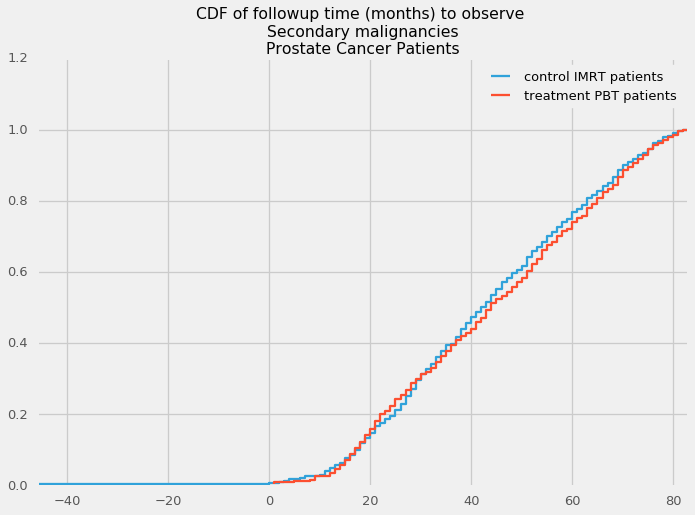

In [110]:
ax = dffollowupcontrol.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(label='control IMRT patients',
                                                                            drawstyle='steps')
dffollowuptreatment.followup_months.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps',
                                                                                          ax=ax,
                                                                            label='treatment PBT patients')

plt.title("CDF of followup time (months) to observe \nSecondary malignancies\nProstate Cancer Patients");
plt.legend()

In [111]:
print(df[prostatefilter & df['patient_id'].isin(controlindices)]['agedx2'].value_counts().sum(),
      df[prostatefilter & df['patient_id'].isin(controlindices)]['agedx2'].shape)

48 (772,)


In [112]:
print(df[prostatefilter & df['patient_id'].isin(treatmentindices)]['agedx2'].value_counts().sum(),
      df[prostatefilter & df['patient_id'].isin(treatmentindices)]['agedx2'].shape)

33 (772,)


# <font color="#E56717">Assess the statistical significance of this difference with Bayesian A/B testing</font>

In [113]:
probcontrol = 48/772
probtreatment = 33/772
print(probcontrol,probtreatment)

0.06217616580310881 0.042746113989637305


In [114]:
controltotal = 772
treatmenttotal = 772
controlsecondary = 48
treatmentsecondary = 33

In [115]:
TREATMENT_SECONDARY = treatmentsecondary
CONTROL_SECONDARY = controlsecondary
TREATMENT_TOTAL = treatmenttotal
CONTROL_TOTAL = controltotal
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1
posterior_treatment = beta(alpha_prior + TREATMENT_SECONDARY, beta_prior + TREATMENT_TOTAL - TREATMENT_SECONDARY)
posterior_control = beta(alpha_prior + CONTROL_SECONDARY, beta_prior + CONTROL_TOTAL - CONTROL_SECONDARY)
samples = 2000000
samples_posterior_treatment = posterior_treatment.rvs(samples)
samples_posterior_control = posterior_control.rvs(samples)
(samples_posterior_control > samples_posterior_treatment).mean()

0.95585900000000001

In [117]:
mpld3.disable_notebook()

(0, 0.15)

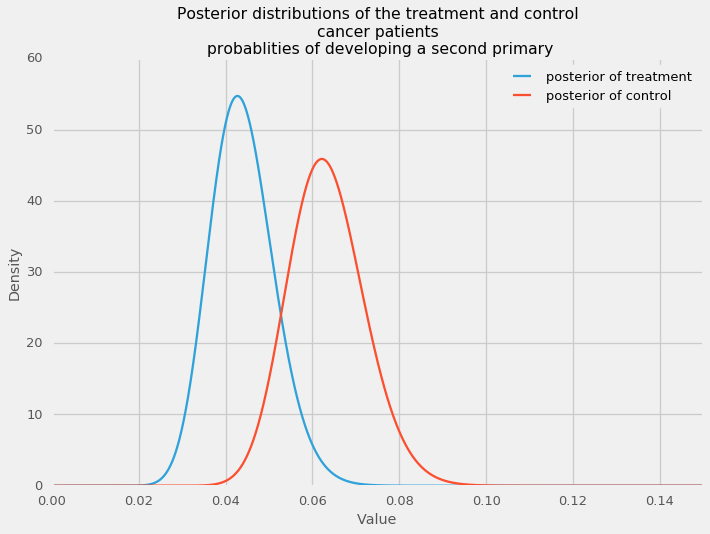

In [118]:
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_treatment.pdf(x), label='posterior of treatment')
plt.plot(x, posterior_control.pdf(x), label='posterior of control');
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the treatment and control
cancer patients\n probablities of developing a second primary""")
plt.legend();
plt.xlim(0,.15)

# <font color="#E56717">Quantify the signficance with t-tests and wilcoxon test</font>

In [120]:
d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))

In [123]:
control_agedx2 = df[df['patient_id'].isin(controlindices)]['agedx2'].notnull().astype('int')
treatment_agedx2 = df[df['patient_id'].isin(treatmentindices)]['agedx2'].notnull().astype('int')
dfagedx2_comp = pd.DataFrame({'control_id': control_agedx2.index,
                             'control_agedx2': control_agedx2.values,
                             'treatment_id': treatment_agedx2.index,
                             'treatment_agedx2': treatment_agedx2.values})

In [124]:
from collections import OrderedDict
secondcontrol = OrderedDict()
for i in range(len(list(controlindices))):
    secondcontrol[controlindices[i]] = control_agedx2.loc[list(controlindices)[i]]
    
secondtreatment = OrderedDict()
for i in range(len(list(treatmentindices))):
    secondtreatment[treatmentindices[i]] = treatment_agedx2.loc[list(treatmentindices)[i]]

In [125]:
q = list(secondcontrol.items())

secondcontrolvals = [q[p][1] for p in range(len(list(secondcontrol.items())))]

secondcontrolindex = [q[p][0] for p in range(len(list(secondcontrol.items())))]

In [126]:
q = list(secondtreatment.items())

secondtreatmentvals = [q[p][1] for p in range(len(list(secondtreatment.items())))]

secondtreatmentindex = [q[p][0] for p in range(len(list(secondtreatment.items())))]

In [127]:
dfsecond = pd.DataFrame({'control_vals': secondcontrolvals,
                               'control_ids': secondcontrolindex,
                               'treatment_vals': secondtreatmentvals,
                               'treatment_ids': secondtreatmentindex})

# <font color="#E56717">Let's restrict to just the prostate cancer matched pairs</font>

In [128]:
ptreat = list(set(df[df.site1.str.contains('prostate',
case=False,na=False) & df.patient_id.isin(treatmentindices)].patient_id.values))

In [129]:
dfdeux = dfsecond[dfsecond.treatment_ids.isin(ptreat)].copy()
dfdeux.shape

(772, 4)

In [130]:
dfdeux.head()

,control_ids,control_vals,treatment_ids,treatment_vals
0,4401133015,0,4461122095,0
1,8893038343,0,8894079354,0
2,8824062394,0,8866044400,0
3,8824008390,0,8814032372,0
4,8750033580,0,8713044550,0


In [131]:
d_t_c['4461122095']

'4401133015'

In [132]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfdeux.control_vals.as_matrix(),
               dfdeux.treatment_vals.as_matrix())

print(t,p)

1280.0 0.0914819210568


In [133]:
from scipy.stats import ranksums, ttest_rel

t, p = ttest_rel(dfdeux.control_vals.as_matrix(),
               dfdeux.treatment_vals.as_matrix())

print(t,p)

1.68965813729 0.0914976464495


In [134]:
from scipy.stats import ranksums, ttest_ind

t, p = ttest_ind(dfdeux.control_vals.as_matrix(),
               dfdeux.treatment_vals.as_matrix())

print(t,p)

1.71270063903 0.0869686594262


In [135]:
dfdeux['diff'] = dfdeux.control_vals - dfdeux.treatment_vals
dfdeux['diff'].value_counts(normalize=True)

 0    0.897668
 1    0.060881
-1    0.041451
Name: diff, dtype: float64

# <font color="#E56717">Look at some matched pairs</font>



In [137]:
goodcols_eval = ['m_sex','marst1','srace','nhiade','grade1','site1','lat1','lat_1','lng_1',
                 'elevation_1','histrec1',
            'modx1','birthyr','agedx1','yrdx1']


In [138]:
df[goodcols_eval].loc[[controlindices[0],treatmentindices[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4401133015,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,40.2589,-74.124,129.992,8140-8398: adenomas and adenocarcinomas,Jun,1942,67,2010
4461122095,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,40.2589,-74.124,129.992,8140-8398: adenomas and adenocarcinomas,Jun,1943,68,2011


In [139]:
choroidindex = list(df[goodcols_eval][df.site1.str.contains('choroid',case=False,na=False)].index)

treatmentchoroid = [a for a in set(choroidindex).intersection(set(treatmentindices))]


#####################################################################################################

lungindex = list(df[goodcols_eval][df.site1.str.contains('lung',case=False,na=False)].index)

treatmentlung = [a for a in set(lungindex).intersection(set(treatmentindices))]

############################################################################################################


cerebralindex = list(df[goodcols_eval][df.site1.str.contains('cerebral',case=False,na=False)].index)

treatmentcerebral = [a for a in set(cerebralindex).intersection(set(treatmentindices))]

##############################################################################################################

esophagusindex = list(df[goodcols_eval][df.site1.str.contains('esophagus',case=False,na=False)].index)

treatmentesophagus = [a for a in set(esophagusindex).intersection(set(treatmentindices))]

#####################################################################################################################


breastindex = list(df[goodcols_eval][df.site1.str.contains('breast',case=False,na=False)].index)

treatmentbreast = [a for a in set(breastindex).intersection(set(treatmentindices))]

In [140]:
df[goodcols_eval].loc[[d_t_c[treatmentchoroid[0]],treatmentchoroid[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
2215176050,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Left: origin of primary,42.0882,-93.9878,1096.17,8720-8799: nevi and melanomas,Feb,1934,72,2007
8831026333,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...",Choroid,Left: origin of primary,39.6446,-121.554,885.724,8720-8799: nevi and melanomas,Feb,1939,68,2008


In [141]:
df[goodcols_eval].loc[[d_t_c[treatmentlung[0]],treatmentlung[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4304141320,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Right: origin of primary,32.7551,-93.6623,247.575,"8010-8049: epithelial neplasms, NOS",Mar,1941,66,2008
8885077334,Female,Widowed,White,Non-Spanish-Hispanic-Latino,"cell type not determined, not stated or not ap...","Upper lobe, lung",Right: origin of primary,32.7157,-117.161,49.9128,"8010-8049: epithelial neplasms, NOS",Mar,1943,65,2009


In [142]:
df[goodcols_eval].loc[[d_t_c[treatmentesophagus[0]],treatmentesophagus[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
4408106073,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.9653,-74.3118,58.8656,8140-8398: adenomas and adenocarcinomas,Dec,1929,77,2006
4473112043,Male,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade III; grade iii, grade 3; poorly differen...",Lower third of esophagus,Not a paired site,39.8592,-75.0144,49.2433,8140-8398: adenomas and adenocarcinomas,Dec,1928,79,2007


In [143]:
df[goodcols_eval].loc[[d_t_c[treatmentbreast[0]],treatmentbreast[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,elevation_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,,
8757024520,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left: origin of primary,34.2515,-84.4803,956.948,8500-8549: ductal and lobular neoplasms,Sep,1943,66,2010
8888027441,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left: origin of primary,33.9533,-117.396,827.484,8500-8549: ductal and lobular neoplasms,Sep,1944,65,2010


In [144]:
dgt = df[goodcols_eval].loc[treatmentindices].copy()
dgc = df[goodcols_eval].loc[controlindices].copy()
from mpl_toolkits.basemap import Basemap

In [145]:
centers_dict = {'Davis, CA': [38.5568118,-121.7700491],
               'Loma Linda, CA': [34.0428589,-117.2838294],
               'Boston, MA': [42.3132878,-71.1975851],
               'Seattle, WA': [47.6147624,-122.4763332],
               'Bloomington, IN': [39.1711919,-86.602058],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'Houston, TX': [29.8168809,-95.6821725],
               'Oklahoma City, OK': [35.4823226,-97.7600756],
               'Warrenvlile, IL': [41.8247102,-88.2168148],
               'Philadelphia, PA': [40.004668,-75.2584614],
               'Hampton, VA': [37.0403431,-76.4311508],
               'Somerset, NJ': [40.5012296,-74.507752],
               'St. Louis, MO': [38.6530166,-90.3838907],
               'Knoxville, TN': [35.9583816,-84.0655115],
               'San Diego, CA': [32.8242389,-117.3760429],
               'Jacksonville, FL': [30.3446899,-82.0013407],
               'New Brunswick, NJ': [40.4882392,-74.4763898],
               'Dallas Fort Worth, TX': [32.7724978,-97.2485344],
               'Phoenix, AZ': [33.6050976,-112.4059302],
               'Rochester, MN': [43.9959015,-92.6216003],
               'Orlando, FL': [28.4810968,-81.5091799],
               'Miami, FL': [25.7823071,-80.3012157]}

In [146]:
center_lats = [l[0] for l in centers_dict.values()]
center_lngs = [l[1] for l in centers_dict.values()]

# <font color="#E56717">It is informative to plot the locations of the PBT treatment and IMRT controls on a map, along with the location of the PBT centers</font>

* <span style="font-size:1.5em;">Knoxville, TN; Warrenville, IL; Philadelphia, PA; Seattle, WA</span>
* <span style="font-size:1.5em;">Loma Linda, CA; San Diego, CA; Oralando, FL; Bloomington, IN (now closed)</span>
* <span style="font-size:1.5em;">Rochester, MN; New Brunswick, NJ; Houston, TX; St. Louis, MO</span>
* <span style="font-size:1.5em;">Miami, FL; Davis, CA; Dallas Fort-Worth, TX; Boston, MA</span>
* <span style="font-size:1.5em;">Somerset, NJ; Oklahoma City, OK; Jacksonville, FL; Phoenix, AZ</span>
* <span style="font-size:1.5em;">Hampton, VA</span>

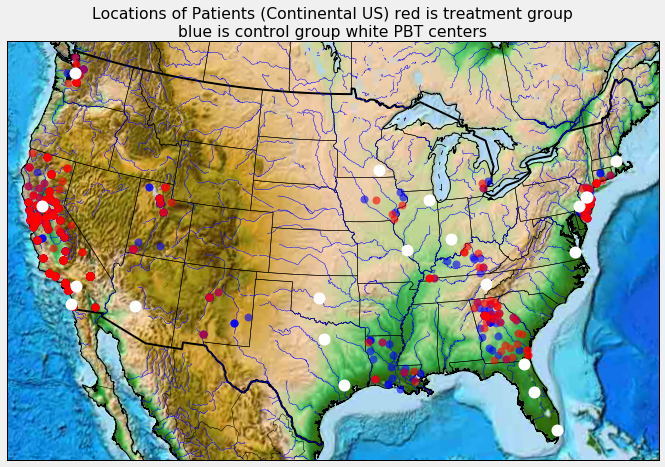

In [147]:
# Lambert Conformal map of USA lower 48 states
mpld3.disable_notebook()
m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
  urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
  lon_0=-95, resolution='h', area_thresh=10000)

m.drawcoastlines()
# draw country boundaries
m.drawcountries(linewidth=2)
# draw states boundaries (America only)
m.drawstates()
#m.bluemarble()
m.etopo()

# fill the background (the oceans)
m.drawmapboundary(fill_color='aqua')
# fill the continental area
# we color the lakes like the oceans
#m.fillcontinents(color='coral',lake_color='aqua')

m.drawrivers(color='#0000ff')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = m(dgt['lng_1'].values, dgt['lat_1'].values)
xc, yc = m(dgc['lng_1'].values, dgc['lat_1'].values)
xcenters, ycenters = m(center_lngs, center_lats)

# Plot them using round markers of size 6
#m.plot(x, y, 'ro', markersize=8,alpha=.7)
m.plot(xc,yc, 'bo', markersize=8,alpha=.6)
m.plot(x, y, 'ro', markersize=8,alpha=.6)
m.plot(xcenters, ycenters, 'wo', markersize=12)

plt.title("Locations of Patients (Continental US) red is treatment group\nblue is control group white "+\
         "PBT centers")

plt.savefig('pure_map_with_centers.png', format='png')
plt.show()

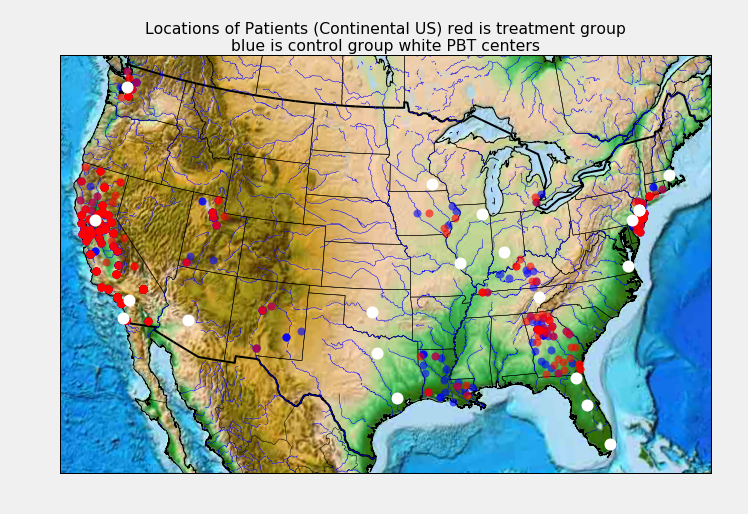

In [148]:
## This is for an `png` image
from IPython.display import Image

fig = Image(filename=('pure_map_with_centers.png'),embed=True)
fig